<img src="./img/metro_madrid.jpg" alt="drawing" width="500"/>

# Work Journal - Transport and income in the Community of Madrid

This project aims to analyse the behaviour on the election of the means of transport by the citizens of the Community of Madrid, studying possible links to their income. For this occasion, the [Survey of Mobility of 2018](https://datos.comunidad.madrid/dataset/resultados-edm2018) by Consorcio Regional de Transportes de Madrid (CRTM), is the main source.

For the income calculations, several tables from  [Survey of Life Conditions](https://www.madrid.org/iestadis/fijas/estructu/sociales/iecv19.htm) are used.

Finally, meteorological data is retrieved via API from [AEMET](https://opendata.aemet.es/centrodedescargas/inicio), the Spanish Agency of Meteorology.

The main hypothesis of this project is to prove whether **there is a connection between the preferred mode of transport of the citizens and their income** in the Community of Madrid. Some other aspects are tested throughout the study:
+ Higher-income users choose the car as a first transportation option when they go to work.
+ Therefore, lower-income workers use the different modes of public transport.
+ Women use public transport more frequently than men, when going to work.
    + This case is discussed both taken into account their income; and isolating this variable.
+ Weather has little impact on the workers' behaviour when going to work.


## Assumptions
There are some points that have to be taken into account through the analysis:
+ The data by the CRTM is the latest available, but the survey was conducted during 2018.
    + The usage of the whole network covered by CRTM on 2022 was at [85.1 % compared to 2019](https://www.crtm.es/media/4eedagri/informe_anual_2022_eng.pdf), prior to the impact of COVID-19. We assume that the numbers will be similar by the time of making this project (October 2024) and that there hasn't been any deep change on the behaviour of the users because of it.
+ The real income from the users is unknown to us. As it is a constructed indicator (as explained above), it is important to point out:
    + **Income is not wealth**. Wealth is a much more complicated and obscure indicator. We must take into account that this analysis won't cover, for example, citizens with low income but high wealth (which may behave similarly to those with high income or not).
    + The Survey of Life Conditions publishes the **main** income, which is the used data to build said indicator.
    + Four socioeconomic conditions are used for this: **Level of education** (4 categories), **gender** (2), **occupation** (5) and **age** (5). This means the constructed indicator will have a maximum of **200 unique values**.
+ Public transport is treated **as a whole**, and possible differences between each mean of public transport aren't discussed in this project.


## Table of contents

1. [Data collecting](#10)
2. [Data treatment](#20)
    - [Code for treatment](#21)
3. [Data analysis](#30)
    - [Code for analysis](#31)
4. [Income calculation](#40)
    - [Code for income and its analysis](#41)
5. [Main hypothesis](#50)
6. [Secondary hypothesis](#60) 

<a id="10"></a> <br>  

## 1. Data collecting

For this project, the following sources are used:
### Consorcio Regional de Transportes de Madrid
As mentioned above, the main source for transportation comes from the 2018 CRTM Survey of Mobility, obtained from [here](https://datos.crtm.es/search?q=edm2018). Two datasets are primarily utilised:
+ EDM2018VIAJES: which cointains information about why the individual is moving around, when the trip started and the main mode of transportation used.
+ EDM2018INDIVIDUOS: with information related to the individual (age, level of studies, occupation...).

This survey was conducted from February to June 2018.

### AEMET
Historical data from the Spanish Agency of Meteorology (AEMET) is extracted, for the above-mentioned period. This was done vie their [API](https://opendata.aemet.es/centrodedescargas/inicio).

### Madrid's Institute of Statistics
The Survey of Life Conditions is used to retrieve the mean income of different socioeconomic conditions. They are available from [here](https://www.madrid.org/iestadis/fijas/estructu/sociales/iecv19.htm)

<a id="20"></a> <br>

## 2. Data treatment

A big part of the work is encapsulated into functions, inside a utils.py which can be found in the "utils" folder:

In [1]:
import pandas as pd
from utils import utils as ut

A first function helps us download the AEMET data, storing them into a "treated" folder inside "data". The AEMET API restores the connection with each download, so this is becomes helpful to minimise the calls to their service:

In [2]:
#ut.retrieve_aemet()

It was only used once at the start of the project, but it needs a URL which is given by AEMET. data_destination is an argument so the user can choose where to store the output, in a csv.

Main data is extracted and treated with the function `main_data_extraction`:

In [3]:
# ut.main_data_extraction("./data/raw/EDM2018INDIVIDUOS.xlsx","./data/raw/EDM2018VIAJES.xlsx",'./data/treated/aemet_weather.csv','./data/treated/transp.csv')
# df_transp = pd.read_csv("./data/treated/transp.csv")

This function takes four arguments: the mobility survey for individuals, the trips' data, the database in csv extracted by the previous function; and a path where the final csv will be stored.

Given the weight of the original databases, this function is quite slow on its execution. That is why it will only create the csv if there isn't already one created on the destination. If it is not the case:

1. Reads as Pandas dataframes the input paths.
2. Creates a common dataframe with the three origins, via `main_dfs_treat` function (explained below).
3. Applies some conversions to this common dataframe with the function `transp_conversion`.
4. Stores the dataframe into a csv.

In [4]:
# ut.main_dfs_treat(trip,indiv,weather)

This function is used inside `main_data_extraction` and takes three arguments: individuals' survey, trips' survey, and meteorological dataframes.
+ For the **meteorological** dataframe, it creates a new column "datemerge", which will be used for the merge with the output.
+ In the **individual** dataframe:
    + It also creates a "datemerge", in a similar fashion as in meteorological, and merges both dataframes. It keeps the mean temperature (tmed) and rainfall (prec). The latter will be most of used through the analysis.
    + Creates an unique identifier for the individuals, concatenating the if of the household with the individual.
    + Renames the main columns, so they have a more treatable name.
    + The columns which are not found of interest are filtered out.
+ In the **trips'** dataframe:
    + Two new ids: id_indiv (same created in individual), and id_trip (id_indiv plus the trip identifier). **There are several trips made by the same individual on the same day**, but they are accounted as relevant for the study.
    + Renaming and filtering of the relevant variables.
    + And makes a final merge with the individual dataframe.

Finally, tmed and prec are converted into flouat type. The function returns a totally treated dataframe, so it can be used throughout the `main_data_extraction`.

In [5]:
# ut.transp_conversion(df_transp)

Converts most of the categorical info, which is originally stored as integers. It also renames the necessary values.

Se encarga de convertir gran parte de la información categórica, que se almacena como tipo entero. Renombra los valores que sean necesarios.

In this function some of the categories are grouped: for example, 'public' accounts for all kinds of public transport, whilst 'car' takes all of its modalities (trip where the individual is the driver or not, trip by private or personal car...). **It is important to note that taxi trips are excluded from 'car'**. 

The function converts info for the following columns:
+ **transport**.
+ **reason** (why the trip is made).
+ **activity** (occupation of the individual: worker, student, retired, jobless...).
+ **studies** (level of the studies from the individual).
+ **gender**.
+ **week_day** (Monday-Thursday).
+ A new categorical variable is created: **weather**, which is given a 'dry' value when prec is less than 0.1, and 'rain' otherwise.

A detailed overview of the transformation can be found in the utils.py. The function returns the dataframe with all the applied changes, so it keeps being used by `main_data_extraction`.

In [6]:
# ut.aux_data_extraction()

This is the function that extracts the needed data for the income, from the Survey of Life Conditions. It takes four sources from it:
+ Gender and age, included in the same table.
+ Education.
+ Occupation.

In all of them, a **normalization** with mean 1 is made. It returns three dataframes, with the cited origins.

<a id="21"></a> <br>  

### Code for treatment

In [7]:
import pandas as pd
from utils import utils as ut

In [8]:
ut.main_data_extraction("./data/raw/EDM2018INDIVIDUOS.xlsx","./data/raw/EDM2018VIAJES.xlsx",'./data/treated/aemet_weather.csv','./data/treated/transp.csv')
df_transp = pd.read_csv("./data/treated/transp.csv")
df_gender_age, df_educ, df_occup = ut.aux_data_extraction()

Extracting data...
./data/treated/transp.csv already exists
Extracting auxiliary data...
Auxiliary data extracted


<a id="30"></a> <br>  

## 3.- Preliminary analysis

At a first look we see a quite clean dataframe, with no null values. Most of the needed transformations have been already done on previous steps. We start by generating some graphs that will give us a glace over the main categorical variables:

In [9]:
# ut.pie_charts(pies,df)

The next function creates a csv that compares the use of transports on dry and rainy days:

In [10]:
# ut.dry_rain(df_transp)

And the next function generates an analysis of the individuals behaviour taken weather into account, given the data of the previous function:

In [11]:
# ut.weather_change(df_weather,df_weather_work)

It generates two bar charts: general difference on trasport usage, and difference on workers, which the main hypothesis is based upon.


<a id="31"></a> <br>  

### Code for analysis

In [12]:
df_transp.head()

,id_indiv,id_trip,start_trip,transport,freq,reason,distance,trip_pond,gender,age,...,activity,day,month,year,week_day,datemerge,tmed,prec,weather,income
0,1891,18911,800,car,1,work,6.660582,66.304668,male,28,...,worker,25,April,2018,wednesday,2018-4-25,20.8,0.0,dry,167.75
1,1891,18912,1800,car,1,work,6.660582,66.304668,male,28,...,worker,25,April,2018,wednesday,2018-4-25,20.8,0.0,dry,167.75
2,2441,24411,800,car,1,work,6.586497,66.304668,male,36,...,worker,26,April,2018,thursday,2018-4-26,20.2,0.0,dry,240.75
3,2441,24412,1800,car,1,work,6.586497,66.304668,male,36,...,worker,26,April,2018,thursday,2018-4-26,20.2,0.0,dry,240.75
4,2442,24421,1113,walking,1,shopping,0.203441,69.473571,female,35,...,jobless,26,April,2018,thursday,2018-4-26,20.2,0.0,dry,153.75


In [13]:
df_transp.info()

<class 'pandas.core.frame.DataFrame'>
Index: 222672 entries, 0 to 222671
Data columns (total 22 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   id_indiv    222672 non-null  int64  
 1   id_trip     222672 non-null  int64  
 2   start_trip  222672 non-null  int64  
 3   transport   222672 non-null  object 
 4   freq        222672 non-null  int64  
 5   reason      222672 non-null  object 
 6   distance    222672 non-null  float64
 7   trip_pond   222672 non-null  float64
 8   gender      222672 non-null  object 
 9   age         222672 non-null  int64  
 10  spanish     222672 non-null  int64  
 11  studies     222672 non-null  object 
 12  activity    222672 non-null  object 
 13  day         222672 non-null  int64  
 14  month       222672 non-null  object 
 15  year        222672 non-null  int64  
 16  week_day    222672 non-null  object 
 17  datemerge   222672 non-null  object 
 18  tmed        222672 non-null  float64
 19  prec   

223000 rows, and no nulls are detected

In [14]:
df_transp.describe(include='all')

,id_indiv,id_trip,start_trip,transport,freq,reason,distance,trip_pond,gender,age,...,activity,day,month,year,week_day,datemerge,tmed,prec,weather,income
count,2.226720e+05,2.226720e+05,222672.000000,222672,222672.000000,222672,222672.000000,222672.000000,222672,222672.000000,...,222672,222672.000000,222672,222672.0,222672,222672,222672.000000,222672.000000,222672,222672.000000
unique,NaN,NaN,NaN,4,NaN,6,NaN,NaN,2,NaN,...,5,NaN,5,NaN,4,67,NaN,NaN,2,NaN
top,NaN,NaN,NaN,car,NaN,work,NaN,NaN,female,NaN,...,worker,NaN,April,NaN,thursday,2018-5-10,NaN,NaN,dry,NaN
freq,NaN,NaN,NaN,88861,NaN,61806,NaN,NaN,121144,NaN,...,106061,NaN,66747,NaN,67316,6423,NaN,NaN,128978,NaN
mean,2.628231e+07,2.710087e+08,1383.160725,NaN,1.915944,NaN,7.344174,71.152602,NaN,44.569272,...,NaN,15.827073,NaN,2018.0,NaN,NaN,13.155673,3.306013,NaN,232.280894
std,1.146058e+07,1.937172e+08,450.386521,NaN,1.208929,NaN,57.466740,43.856310,NaN,20.117328,...,NaN,8.210610,NaN,0.0,NaN,NaN,5.261546,6.864867,NaN,71.392997
min,1.891000e+03,1.891100e+04,0.000000,NaN,1.000000,NaN,0.000000,2.611298,NaN,4.000000,...,NaN,1.000000,NaN,2018.0,NaN,NaN,3.000000,0.000000,NaN,96.250000
25%,1.841784e+07,1.843761e+08,935.000000,NaN,1.000000,NaN,0.650814,50.881669,NaN,29.000000,...,NaN,9.000000,NaN,2018.0,NaN,NaN,8.200000,0.000000,NaN,190.000000
50%,3.151110e+07,3.151714e+08,1400.000000,NaN,1.000000,NaN,2.115702,62.468900,NaN,47.000000,...,NaN,16.000000,NaN,2018.0,NaN,NaN,14.400000,0.000000,NaN,245.250000
75%,3.469703e+07,3.471157e+08,1753.000000,NaN,3.000000,NaN,7.630491,78.678446,NaN,59.000000,...,NaN,22.000000,NaN,2018.0,NaN,NaN,18.400000,2.600000,NaN,289.750000


Some charts showing the main variables for the analysis:

Generating pie charts...


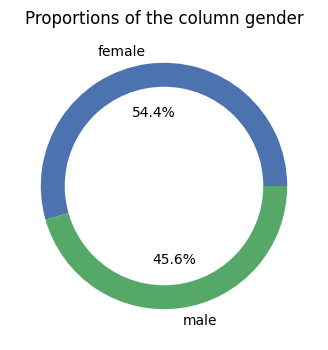

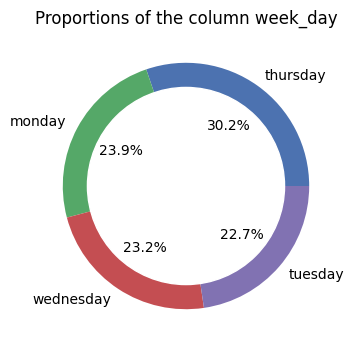

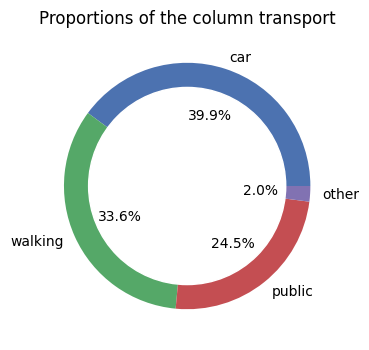

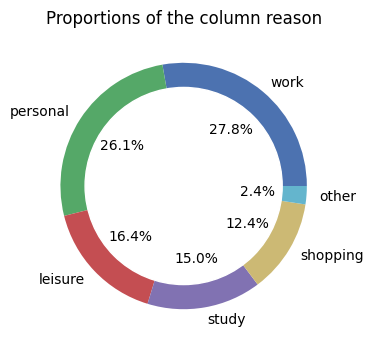

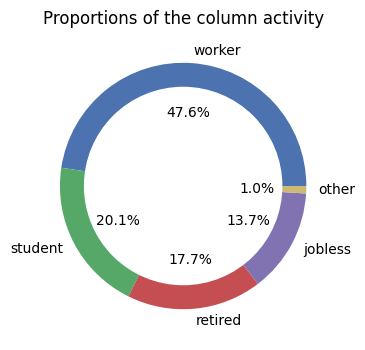

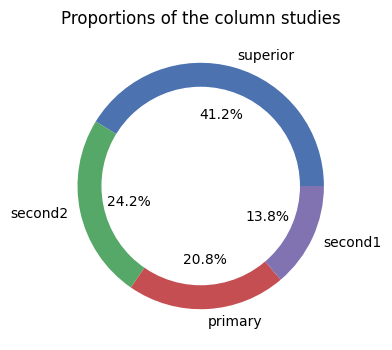

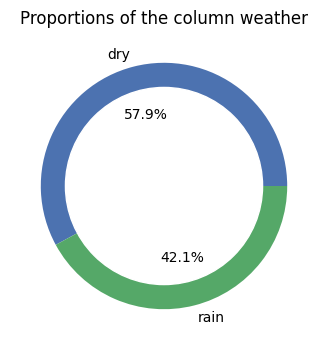

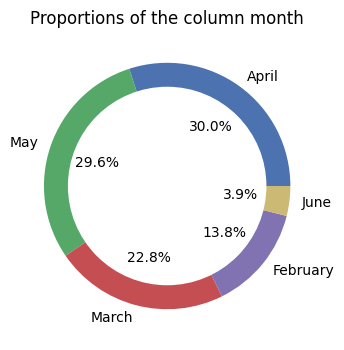

Pie charts generated in /img/plots/pies
Generating dry/rain comparison
Dry/rain comparison saved on data/output


In [15]:
ut.pie_charts(['gender','week_day','transport','reason','activity','studies','weather','month'],df_transp)
ut.dry_rain(df_transp)

`weather_change` lets us see the changes of the usage of transport when it rains, in percentual points. As we can see there are no big differences: the car is used about a 3.6% more, which coincides with the drop of walking trips.

There are even less differences when only workers are taken into account. Cars are used only a 1.5% more, with slight decreases from public transport and walking. None of them get to a 1% of change.

Even if little differences are seen, the sample is large enough that we can focus the study on **dry days** for the main hypothesis.

Plotting weather comparison...


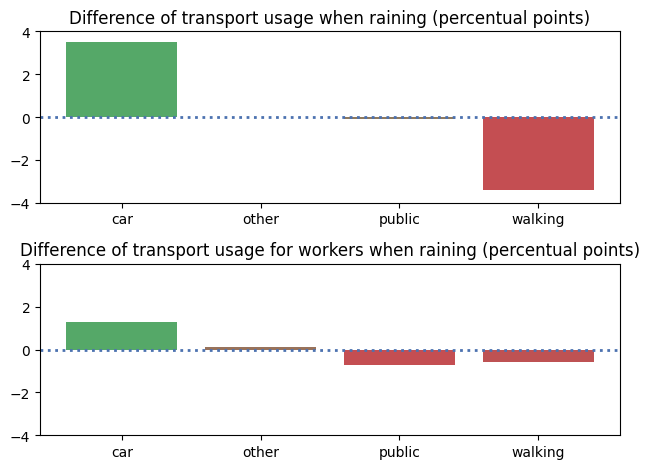

Weather comparison plotted and saved in img/plots/bars/transport_change_weather.png


In [16]:
df_weather = pd.read_csv("./data/output/weather.csv")
df_weather_work = pd.read_csv("./data/output/weather_work.csv")
ut.weather_change(df_weather,df_weather_work)

<a id="40"></a> <br>

## 4. Income calculation

The **income** is a critical variable to test the main hypothesis. It is not given on the Movility Survey, so an **expected income** is created. This is done by extracting the mean income of the known socio-economic conditions. The function for this purpose is `incomme_assign`:

In [17]:
# ut.income_assign(df_main,df_educ,df_occup,df_gender_age)

All travellers are given a base **income** of 100. From there, 25 points are summed for each of the four indicators, multiplied each by the normalised results with mean 1 generated by `aux_data_extraction`:

Todos los viajeros parten de un **income** (renta) de 100. A partir de ahí se le suman 25 puntos por cada uno de los cuatro indicadores, multiplicado por los resultados normalizados con media 1 generados por el aux_data_extraction:
+ **Education** (4 categories)

In [18]:
df_educ

1
Educación primaria o inferior    0.27
Educación secundaria 1ª etapa    0.55
Educación secundaria 2ª etapa    0.70
Educación superior               2.48
Name: 2, dtype: float64

+ **Gender** (2 categories) and **Age** (5 categories)

In [19]:
df_gender_age

,men,women
1,,
Menos de 16 años,-0.18,-0.36
De 16 a 29 años,0.17,-0.04
De 30 a 44 años,1.63,0.83
De 45 a 64 años,2.61,2.11
65 años o más,1.65,1.57


+ **Occupation** (5 categories)

In [20]:
df_occup

1
Ocupados           1.67
Parados           -0.06
Jubilados          2.02
Otros inactivos    0.37
Name: 2, dtype: float64

This means that **income** will have a maximum of 4 x 5 x 2 x 5 = **200 unique values**. This will set most part of the analysis of the main hypothesis.

The function returns a complete dataframe, with this new indicator in a new column. It is important to note that this is an **expected** income, as the real one is unknown to us. It also must be taken into account that the weights of each condition are given arbitrarily. A further knowledge of the respondents and a deeper investigation of the socioeconomic determinants of the income would improve the quality of this indicator.

The next function generates a histogram which helps to understand the distribution of this new column:

In [21]:
# ut.income_dist(df_transp)

<a id="41"></a> <br>

### Code for income and its analysis

Assigning income...
Income assigned and updated in ./data/treated/transp.csv
Plotting income distribution...


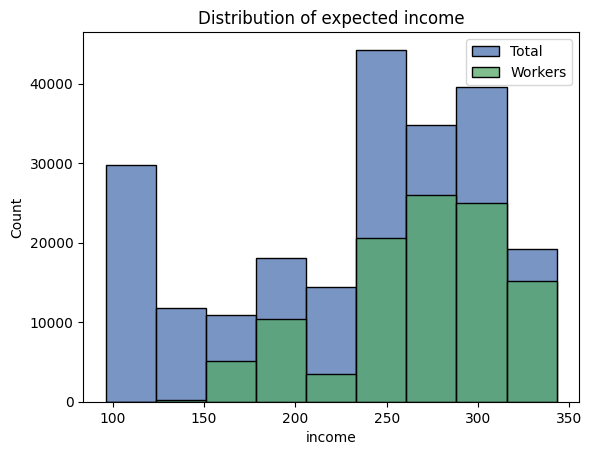

Plotting distribution finished


In [22]:
df_transp = ut.income_assign(df_transp,df_educ,df_occup,df_gender_age)
ut.income_dist(df_transp)

As can be seen, although there are certain lower values, once the analysis is focused on the workers' income most of the results are concentrated on the 240-340 range. This is expected, as being a worker is a condition on the income calculation.

We also have values lower than 100: the normalization of the conditions, although with mean 1, can't prevent for some values to be below the given base for the income.

In [23]:
df_transp['income'].nunique()

122

In [24]:
df_transp[df_transp['activity'] == "worker"]['income'].nunique()

37

Although the maximum unique values for income is 200, we only get **122**. This makes sense, as some conditions are exclusive to each other (p.eg. retired who are younger than 16).

Once we focus on the workers, we get **37 unique values**.

<a id="50"></a> <br>

## 5. Main hypothesis

The goal of this project is to find a relation between **income** and the means of **transport** used by the travelers. The function `hypo_1`is used for the occasion:

In [25]:
# ut.hypo_1(df_filtered, col_compare, title_name,file_name, jitter = False, n_obs = True, compare = 'no')

It displays different box plots depending on the necessities. If there are no comparison between more than one conditions, the colors reflect the median diference of each group. Arguments for the function:
+ df_filtered: Dataframe with a previous filtered applied by the user (it also works with the main df).
+ compare: Whether we want to add an aditional categorical variable to the chart or not.
+ col_compare: Which additional categorical variable we want to add.
+ title_name: Name of the chart.
+ file_name: Name of the generated file, containing the chart.
+ jitter: Whether we want the observations to be shown on the chart, as points.
+ n_obs: Displays the size of the sample for each category (only if compare is false).

Plotting charts for hypothesis 1...
Hypothesis 1 plotted


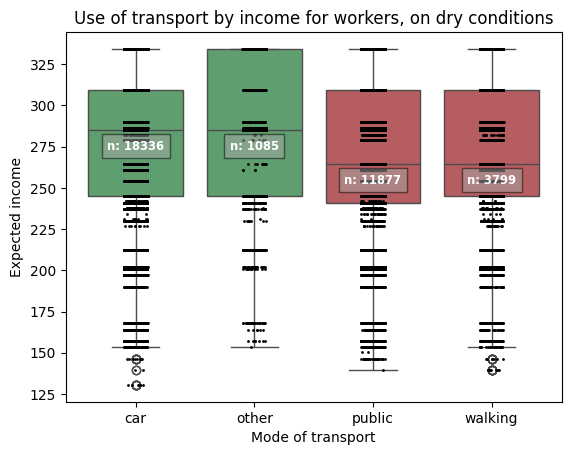

In [26]:
### Comparison of people going to/from work, dry days:
df_transp_dry_work = df_transp[(df_transp["weather"] == "dry") & (df_transp["reason"] == "work")]
ut.hypo_1(df_transp_dry_work,title_name="Use of transport by income for workers, on dry conditions",
          file_name="transport_income_workers_main",jitter=True,n_obs=True)

Transports collected on 'other' have little weight on the sample. The study focus on car, public and walking from now on:

Plotting charts for hypothesis 1...
Hypothesis 1 plotted
Plotting charts for hypothesis 1...
Hypothesis 1 plotted


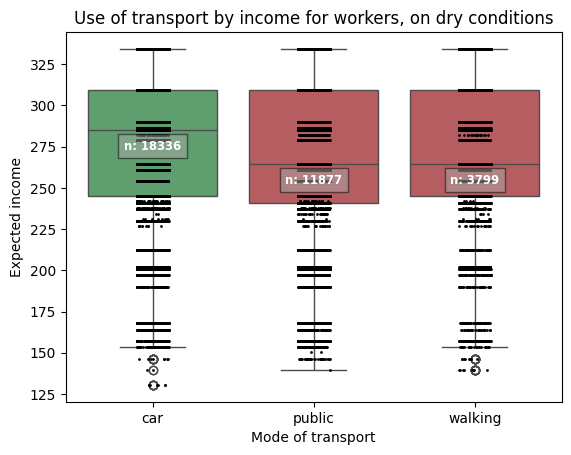

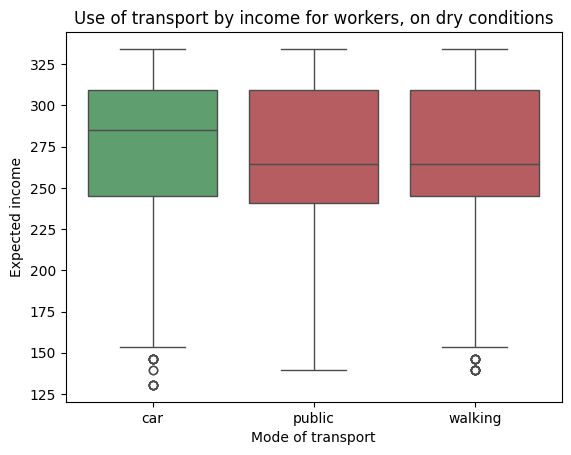

In [27]:
### Main transports, dry weather, reason is working:
df_transp_dry_work_main = df_transp[(df_transp["weather"] == "dry") & (df_transp["reason"] == "work") & (df_transp["transport"].isin(["car","public","walking"]))]
ut.hypo_1(df_transp_dry_work_main,title_name="Use of transport by income for workers, on dry conditions",
          file_name="transport_income_workers_main",jitter=True,n_obs=True)
### Same as above, with no:
df_transp_dry_work_main = df_transp[(df_transp["weather"] == "dry") & (df_transp["reason"] == "work") & (df_transp["transport"].isin(["car","public","walking"]))]
ut.hypo_1(df_transp_dry_work_main,title_name="Use of transport by income for workers, on dry conditions",
          file_name="transport_income_workers_main",jitter=False,n_obs=False)

As can be perceived, **the median income for car users is superior to those using public transport** to working reasons. Walking median is also quite low, compared to car users. It is important to note also that the boxplots have very similar quartiles 1-3, which can be explained by two reasons which were checked on the income generation as a variable:
+ Workers have a **great concentration** on values, between 240 and 340.
+ There are only **37 unique values**.

Could the decision of leaving out rainy days have impacted the result?

Plotting charts for hypothesis 1...
Hypothesis 1 plotted


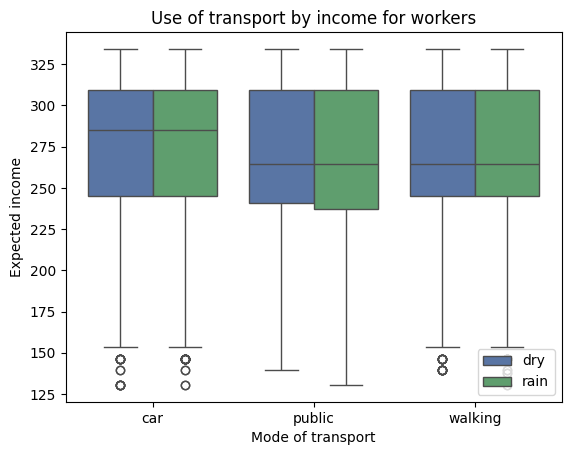

In [28]:
### Comparación of main transport, workers, dry and rainy days:
df_transp_work_main = df_transp[(df_transp["reason"] == "work") & (df_transp["transport"].isin(["car","public","walking"]))]
ut.hypo_1(df_transp_work_main,title_name="Use of transport by income for workers",
          file_name="transport_income_workers",compare=True,col_compare='weather',jitter=False,n_obs=False)

Results are primarily maintained. Actually, the first quartile for public is lower, which indicates that precisely lower incomes use public transport somewhat more frequently on rain conditions.

Therefore, **it can be affirmed that there is a relaltion between the choose of meanns of transport for workers, and their expected income taken into account their socio-economic conditions**.

We advise again about the relative **simple approach on the income generation**. Further analysis is needed to establish a stronger link between these variables.

<a id="60"></a> <br>

## 6. Secondary hypothesis

The second hypothesis of this project is: do women use public transport more frequently than men? This simple hypotesis hides more insights that can be expected at a first glance. `hypo_2` is used for this occasion, which groupes the data as needed and generates a bar chart to display the results:

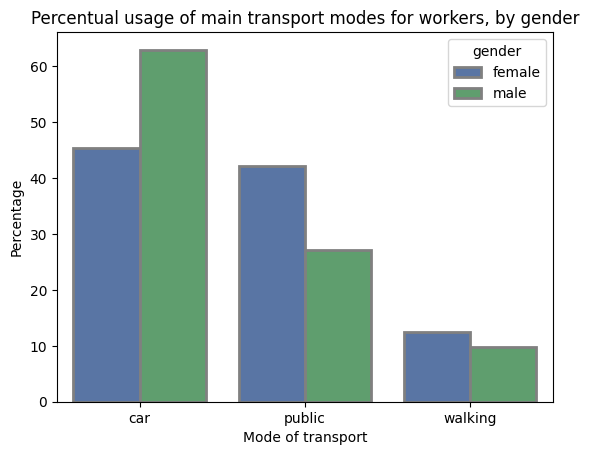

In [29]:
ut.hypo_2(df_transp)

There is an abysmal difference: **not taken income into account**, women workers use the car and public transport in a similar fashion, while men use the car over the public transport over more than 30 percentual points.

**Does gender explain the difference the usage of transport by itself, not taking income into account?**

`hypo_1b` has some slight changes over the original `hypo_1`, which helps on the new comparison. This time, a gender comparison is made:

Plotting charts for hypothesis 1a...
Hypothesis 1 plotted


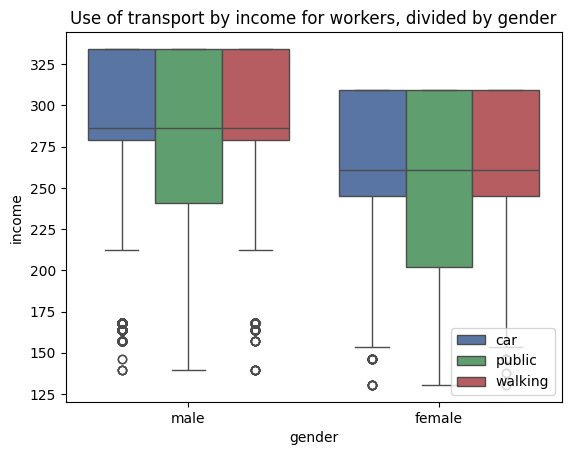

In [41]:
df_transp_work_main = df_transp[(df_transp["reason"] == "work") & (df_transp["transport"].isin(["car","walking","public"]))]
ut.hypo_1b(df_transp_work_main,title_name="Use of transport by income for workers, divided by gender",
          file_name="transport_income_workers_gender",compare=True,col_compare='transport',jitter=False,n_obs=False)

As can be found, once the results are divided by gender, the medians take the same values, regardless of the transport taken. But variations on quartiles 1 and 2 of public transport can be seen: they are way lower than their counterparts on car usage, both on men and women. Therefore, it can be concluded that **there is a difference of transport use noted by the income, regardless of gender**.